In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from evolvepro.src.data import load_dms_data
from evolvepro.src.evolve import directed_evolution_simulation
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error
import pca_visualisation

In [30]:
# load dataset
dataset_name = "jones"
model_name = "esm1b_t33_650M_UR50S"
embeddings_path = "output/dms/embeddings"
labels_path = "output/dms/labels"
embeddings_file_type = "csv"
embeddings_type_pt = "average"
embeddings, labels = load_dms_data(dataset_name, model_name, embeddings_path, labels_path, embeddings_file_type, embeddings_type_pt)

Embeddings and labels are aligned


In [38]:
def model_simulation(
        embeddings,
        labels,
        output_dir,
        predict_all = True,
        activity = "activity",
        cycles = 10,
        num_per_cycle = 10,
        model = RandomForestRegressor(n_estimators=100, criterion='friedman_mse', max_depth=None, min_samples_split=2,
                                        min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0,
                                        max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False,
                                        n_jobs=None, random_state=1, verbose=0, warm_start=False, ccp_alpha=0.0,
                                        max_samples=None)):
    os.makedirs(output_dir, exist_ok=True)
    predictions_list = []
    metrics_list = []

    iteration_old = None
    for iter in range(0, cycles+1):
        if iter == 0:
            # first iteration: randomly select mutants
            selected_variants = np.random.choice(
                labels.loc[labels['variant'] != 'WT', 'variant'],
                size=10, # number of mutants per round
                replace=False
            )
            iteration_old = pd.DataFrame({'iteration': iter, 'variant': selected_variants})
        else:
            # subsequent iterations: train Random Forest and predict on unselected variants
            selected_variants = set(iteration_old['variant'])

            # select embeddings and labels based on variant names
            selected_mask = embeddings.index.isin(selected_variants)

            # split data into training and prediction sets
            X_train = embeddings[selected_mask]
            y_train = labels.loc[selected_mask, activity]

            X_predict = embeddings[~selected_mask]
            variants_to_predict = X_predict.index.tolist()

            # train random forest model
            model.fit(X_train, y_train)

            # make predictions for unseen mutations - used for next step calculations
            y_train_predict = model.predict(X_train)
            y_train_actual = y_train
            y_test_predict = model.predict(X_predict)
            y_test_actual = labels.loc[~selected_mask, activity]
            
            # save predictions 
            df_predictions = pd.DataFrame({
                'iteration': iter,
                'variant': variants_to_predict,
                'predicted_activity': y_test_predict
            })
        
            if predict_all:
            # predict all mutations instead of just unseen ones, and save to output dataframe
                all_predictions = model.predict(embeddings)
                all_variants = embeddings.index.tolist()
                all_predictions_df = pd.DataFrame({
                    'iteration': iter,
                    'variant': all_variants,
                    'predicted_activity': all_predictions
                })

                # save predictions of all mutations
                predictions_list.append(all_predictions_df)
            else:
                # save predictions of only unseen mutations
                predictions_list.append(df_predictions)


            # select the top variants for next iteration
            top_variants = df_predictions.sort_values(by='predicted_activity', ascending=False)
            selected_variants = top_variants.head(num_per_cycle)['variant'].tolist()

            # update iteration_old with the selected variants
            iteration_old = pd.concat(
                [iteration_old, pd.DataFrame({'iteration': iter, 'variant': selected_variants})],
                ignore_index=True
            )

            # calculate metrics
            train_error = mean_squared_error(y_train_actual, y_train_predict)
            test_error = mean_squared_error(y_test_actual, y_test_predict)
            top_variant_index = embeddings.index.isin(selected_variants)
            median_activity = labels.loc[top_variant_index, activity].median()
            top_activity = labels.loc[top_variant_index, activity].max()
            #median_activity = np.median(y_test_predict)
            #top_activity = np.max(y_test_predict)
            next_iter_variants = ' '.join([str(i) for i in selected_variants])

            metrics = {
                'iteration': iter,
                'next_iter_variants': next_iter_variants,
                'train_error': train_error,
                'test_error': test_error,
                'median_activity': median_activity,
                'top_activity': top_activity
            }
            metrics_list.append(metrics)


    final_predictions_df = pd.concat(predictions_list, ignore_index=True)
    final_cycle_predictions = final_predictions_df[final_predictions_df["iteration"]==iter].drop(columns=["iteration"])
    metrics_df = pd.DataFrame(metrics_list)
    final_predictions_df.to_csv(os.path.join(output_dir, "predicted_activities.csv"))
    metrics_df.to_csv(os.path.join(output_dir, "metrics.csv"))
    final_cycle_predictions.to_csv(os.path.join(output_dir, "final_cycle_predictions.csv"))

In [41]:
# variables used for function
model = RandomForestRegressor(n_estimators=100, criterion='friedman_mse', max_depth=None, min_samples_split=2,
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0,
                                max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False,
                                n_jobs=None, random_state=1, verbose=0, warm_start=False, ccp_alpha=0.0,
                                max_samples=None)


model_simulation(
    embeddings = embeddings,
    labels = labels,
    output_dir = "output/RF_simulations",
    predict_all = True,
    activity = "activity",
    cycles = 32,
    num_per_cycle = 12
)


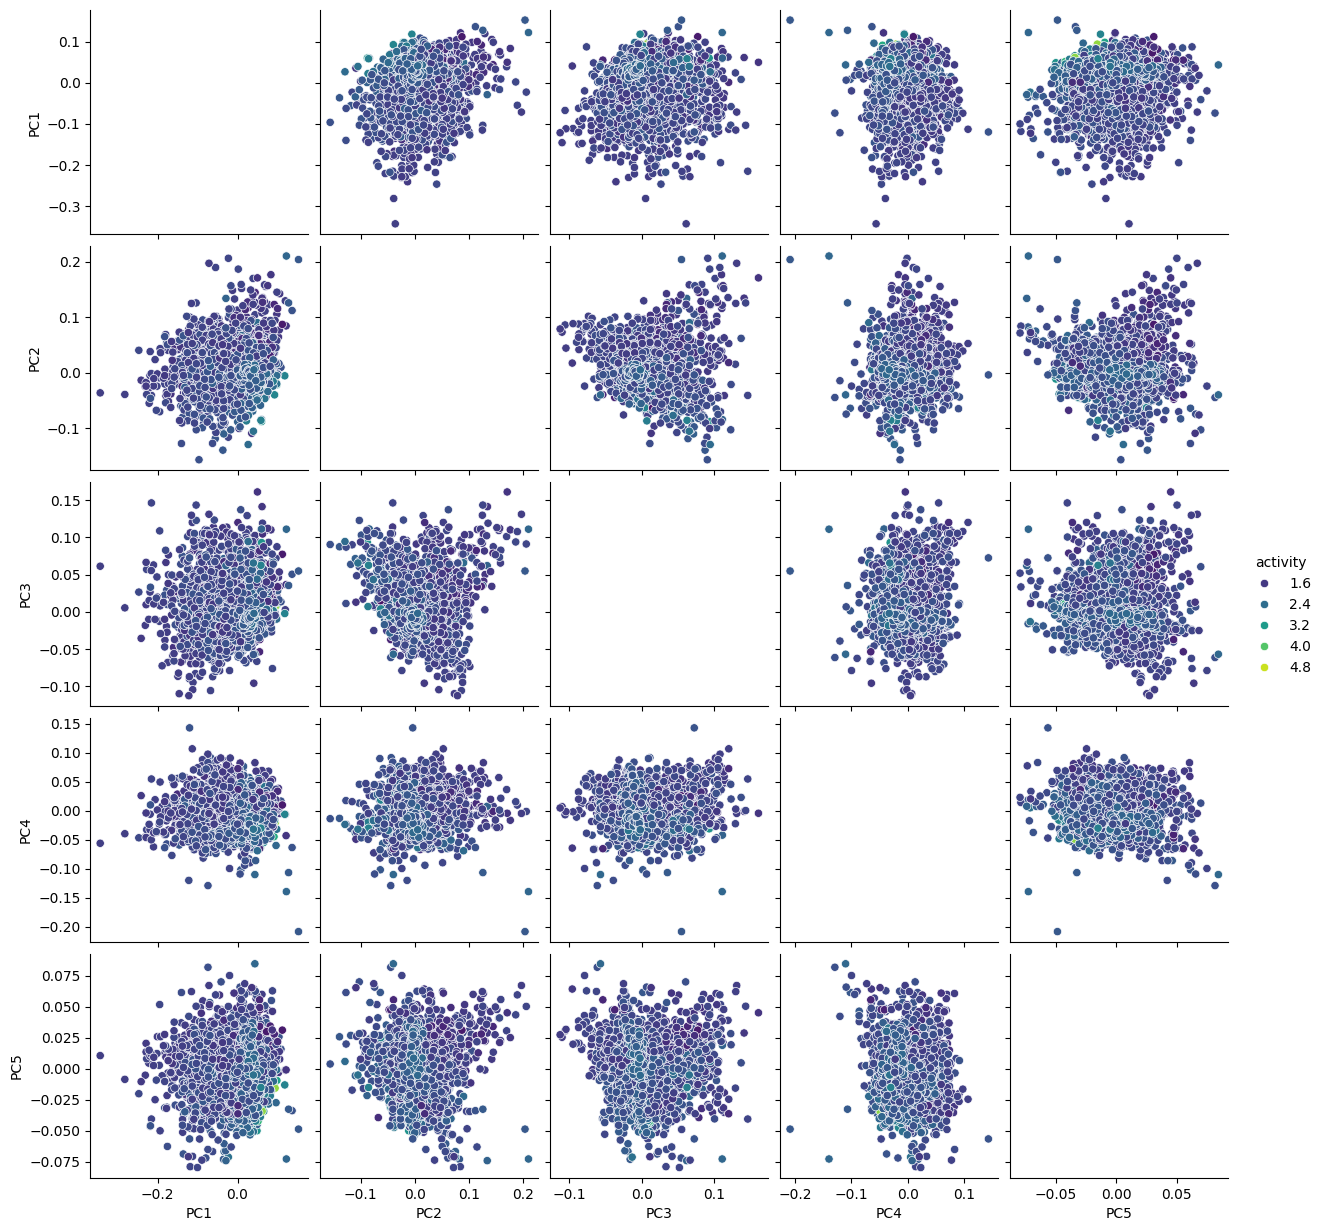

In [42]:
pca = pca_visualisation.Create_PCA(
    embedding_path = "output/dms/embeddings/jones_esm1b_t33_650M_UR50S.csv",
    labels_path = "output/RF_simulations/final_cycle_predictions.csv",
    label_name="predicted_activity",
    n_dims=5
)

pca.visualise_labels()